In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# 3 option for print all columns in the dataframes
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import copy
from datetime import datetime, timedelta
from scipy import stats

import plotly.express as px
template = 'plotly_dark'

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
# import the dataset
dpc_covid19_ita_regioni = pd.read_csv("../input/covid19-italy-regional-data/dpc-covid19-ita-regioni.csv")

# rename the columns 
df = dpc_covid19_ita_regioni.rename(columns={'data':'date',
                                             'stato': 'country',
                                             'codice_regione': 'region_id',
                                             'denominazione_regione':'region',
                                             'ricoverati_con_sintomi':'hospitalized_with_symptoms',
                                             'terapia_intensiva':'intensive_therapy',
                                             'totale_ospedalizzati':'tot_hospitalized',
                                             'isolamento_domiciliare':'home_quarantine',
                                             'totale_attualmente_positivi':'tot_now_positive',
                                             'nuovi_attualmente_positivi':'new_positive',
                                             'dimessi_guariti':'recovered',
                                             'deceduti':'deaths',
                                             'totale_casi':'confirmed',
                                             'tamponi':'swabs'})

## Last Update
↓↓↓


In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + max(df['date']) + color.END)

In [ ]:
# convert the date from string in datetime format for time series analysis
df['date'] = pd.to_datetime(df['date'].str[:10],
format='%Y-%m-%d')
ita = df.copy()
df

In [ ]:
# import the dataset
dpc_covid19_ita_province = pd.read_csv("../input/covid19-italy-regional-data/dpc-covid19-ita-province.csv")
dpc_covid19_ita_province[dpc_covid19_ita_province['denominazione_provincia']=='Torino']

prov = dpc_covid19_ita_province.rename(columns={'data':'date',
                                             'stato': 'country',
                                             'codice_regione': 'region_id',
                                             'denominazione_regione':'region',
                                             'codice_provincia':'province_id',
                                             'denominazione_provincia':'province',
                                             'sigla_provincia':'province_code',
                                             'totale_casi':'confirmed'})
# Delete these row indexes from dataFrame
prov.drop(prov[ prov['date'] ==  'data' ].index , inplace=True)
prov.drop(prov[ prov['province_code'].isnull()].index , inplace=True)
prov['confirmed'] = prov['confirmed'].astype(int)
prov['lat'] = prov['lat'].astype(float)
prov['long'] = prov['long'].astype(float)
prov['date'] = pd.to_datetime(prov['date'].str[:10],format='%Y-%m-%d')

# prov.groupby(by=['region']).sum()
#
prov
# prov['confirmed'] = prov.groupby(['region']).cumsum()
# prov[prov['date'] == max(prov['date'])]

# Summary of activities

* Dynamic Maps
  * Italy (Regions, Provinces)
  * World
* Exponential fit
* SIR Model
* SIR_qp Model

# An overview on Italy 

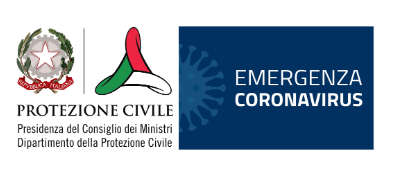

The Dipartimento della Protezione Civile, uploads everyday at 18:30 an update on the spread of the Covid-19 in Italy.

You can found the raw data used in this analysis following the link: -> https://github.com/pcm-dpc/COVID-19

## Scope

In the first section this work tries to provide the reader the right data vizualization tools for boost the comprehension of the global and local spread of the Covid-19.

In the second part, predictive models on the spread of the virus will be given.

In [ ]:
# select the last and most updated data from the dataset for statistics and display it
df_max = df[df['date']==max(df['date'])].sort_values(['confirmed'], ascending=[False])

df_max.columns

Here, an overview of the main insight from the dataset is given

In [ ]:
ita = ita.groupby(by=['date'], as_index=False).sum().sort_values(['date'], ascending=[True])
ita = ita.rename(columns={'region_code':'country'})
ita['country'] = 'ITA'
ita[['date', 'country','confirmed','recovered','deaths']].sort_values(['date'], ascending=[False])

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12,7))

# gca stands for 'get current axis'
ax = plt.gca()

ita.plot(x ='date', y='confirmed', color='blue', kind = 'line',ax=ax)
ita.plot(x ='date', y='deaths', color='red', kind = 'line',ax=ax)
ita.plot(x ='date', y='recovered', color='green', kind = 'line',ax=ax)

plt.legend(['confirmed', 'deaths','recovered'], loc='upper left')
plt.rcParams['figure.facecolor'] = 'xkcd:white'

dict_style_title = {'fontsize':30,
                    'fontweight' : 'bold',
                    'color' : 'black',
                    'verticalalignment': 'baseline'}

plt.title('Italy', fontdict = dict_style_title)
plt.show()

It is noticeable that the trand prensent a drop after the 9 of March, start date of the [quarantine measure](http://www.governo.it/it/articolo/firmato-il-dpcm-9-marzo-2020/14276)  take by Italy as a country.

In [ ]:
df2 = df.copy()
# convert date in the target format for plotting the map
df2['date'] = df2['date'].dt.strftime('%m/%d/%Y')
df[df['date']==max(df['date'])][['date','region','confirmed','deaths','recovered']].sort_values(['confirmed'], ascending=[False])

In [ ]:
fig = px.scatter_geo(df2, 
                     lat = df2["lat"].astype(str), lon = df2["long"].astype(str),
                     color="confirmed", size="confirmed", hover_name="region", 
                     range_color= [0, max(df2['confirmed'])+2],  color_continuous_scale='Bluered',
                     projection="natural earth", animation_frame="date", scope = 'europe', height = 700, size_max  = 70,# template = template,
                     title='Spread in Italy over time: Regions')



fig.show()

In [ ]:
dfp = prov.copy()
# convert date in the target format for plotting the map
dfp['date'] = dfp['date'].dt.strftime('%m/%d/%Y')

In [ ]:
# for now unused
# link source data: -> https://gist.github.com/datajournalism-it/f1abb68e718b54f6a0fe
import geojson
with open("../input/covid19-italy-regional-data/regioni-con-trento-bolzano.geojson") as f:
    gj = geojson.load(f)
gj["features"][0]

In [ ]:
# it can be defined either with color_continuous_scale=px.colors.sequential.Bluered
# for revere the color scheme simply append _r at the end of the name of the color schema  .ex  'Bluered_r'
# style informations: -> https://plot.ly/python/map-configuration/

#     Valid properties:
#         bgcolor
#             Set the background color of the map
#         center
#             plotly.graph_objects.layout.geo.Center instance or dict
#             with compatible properties
#         coastlinecolor
#             Sets the coastline color.
#         coastlinewidth
#             Sets the coastline stroke width (in px).
#         countrycolor
#             Sets line color of the country boundaries.
#         countrywidth
#             Sets line width (in px) of the country boundaries.
#         domain
#             plotly.graph_objects.layout.geo.Domain instance or dict
#             with compatible properties
#         fitbounds
#             Determines if this subplot's view settings are auto-
#             computed to fit trace data. On scoped maps, setting
#             `fitbounds` leads to `center.lon` and `center.lat`
#             getting auto-filled. On maps with a non-clipped
#             projection, setting `fitbounds` leads to `center.lon`,
#             `center.lat`, and `projection.rotation.lon` getting
#             auto-filled. On maps with a clipped projection, setting
#             `fitbounds` leads to `center.lon`, `center.lat`,
#             `projection.rotation.lon`, `projection.rotation.lat`,
#             `lonaxis.range` and `lonaxis.range` getting auto-
#             filled. If "locations", only the trace's visible
#             locations are considered in the `fitbounds`
#             computations. If "geojson", the entire trace input
#             `geojson` (if provided) is considered in the
#             `fitbounds` computations, Defaults to False.
#         framecolor
#             Sets the color the frame.
#         framewidth
#             Sets the stroke width (in px) of the frame.
#         lakecolor
#             Sets the color of the lakes.
#         landcolor
#             Sets the land mass color.
#         lataxis
#             plotly.graph_objects.layout.geo.Lataxis instance or
#             dict with compatible properties
#         lonaxis
#             plotly.graph_objects.layout.geo.Lonaxis instance or
#             dict with compatible properties
#         oceancolor
#             Sets the ocean color
#         projection
#             plotly.graph_objects.layout.geo.Projection instance or
#             dict with compatible properties
#         resolution
#             Sets the resolution of the base layers. The values have
#             units of km/mm e.g. 110 corresponds to a scale ratio of
#             1:110,000,000.
#         rivercolor
#             Sets color of the rivers.
#         riverwidth
#             Sets the stroke width (in px) of the rivers.
#         scope
#             Set the scope of the map.
#         showcoastlines
#             Sets whether or not the coastlines are drawn.
#         showcountries
#             Sets whether or not country boundaries are drawn.
#         showframe
#             Sets whether or not a frame is drawn around the map.
#         showlakes
#             Sets whether or not lakes are drawn.
#         showland
#             Sets whether or not land masses are filled in color.
#         showocean
#             Sets whether or not oceans are filled in color.
#         showrivers
#             Sets whether or not rivers are drawn.
#         showsubunits
#             Sets whether or not boundaries of subunits within
#             countries (e.g. states, provinces) are drawn.
#         subunitcolor
#             Sets the color of the subunits boundaries.
#         subunitwidth
#             Sets the stroke width (in px) of the subunits
#             boundaries.
#         uirevision
#             Controls persistence of user-driven changes in the view
#             (projection and center). Defaults to
#             `layout.uirevision`.
#         visible
#             Sets the default visibility of the base layers.

fig = px.scatter_geo(dfp, 
                     lat = dfp["lat"].astype(str), lon = dfp["long"].astype(str),
                     color="confirmed", size="confirmed", hover_name="province", 
                     range_color= [0, max(dfp['confirmed'])+2], color_continuous_scale='Bluered',
                     projection="natural earth", animation_frame="date", scope = 'europe', height = 700, size_max  = 70,# template = template,
                     title='Spread in Italy over time: Provinces')

# fig.update_geos(visible=True,oceancolor = 'grey',showocean = True, showland = False,countrycolor = 'white', countrywidth = 2, bgcolor ='black', showcountries = True, resolution = 50
#                ,lonaxis={"range":[30, 45]}, lataxis={"range":[37, 50]
    #)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})



fig.show()

# World comparison
The global situation is taken from the dataset [covid_19_clean_complete.csv](https://www.kaggle.com/imdevskp/corona-virus-report)

In [ ]:
full_table = pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv', 
                         parse_dates=['Date'])
formated_gdf = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])
formated_gdf.groupby(['Country/Region']).max().sort_values(['Confirmed'], ascending=[False]).head(10)  # commenta a cambia head (25) per vedere ad esempio i primi 25

In [ ]:
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')

fig = px.scatter_geo(formated_gdf, 
                     locations="Country/Region", locationmode='country names', 
                     color="Confirmed", size='Confirmed', hover_name="Country/Region", 
                     range_color= [0, max(formated_gdf['Confirmed'])+2], color_continuous_scale='Bluered',# template = template,
                     projection="natural earth", animation_frame="Date", size_max = 70, height=800,
                     title='Spread World wide over time')

fig.update_yaxes(automargin=True)
fig.show()

# Trend analysis in Italy

The data is aggregated at country level.


In [ ]:
ita = ita.groupby(by=['date'], as_index=False).sum().sort_values(['date'], ascending=[True])
ita = ita.rename(columns={'region_code':'country'})
ita['country'] = 'ITA'
ita = ita[['date', 'country','confirmed','recovered','deaths']]
ita.head(5)

## Exponential approximation

Hence, it's easy by plotting the confirmed cases data to notice that they could be approximated by an exponential curve.

It's also noticeable a change in the curve after the [Dpcm 9 Marzo 2020](http://www.governo.it/it/articolo/firmato-il-dpcm-9-marzo-2020/14276) 

In [ ]:
from scipy.optimize import curve_fit
import datetime as dt


def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c
#   return a * np.log(b * x) + c

x = ita[['date']]
x = np.array(x['date'].map(dt.datetime.toordinal), dtype=float) #transform your data in a numpy array of floats 
x_scale = x - x[0] # 0 è il giorno attuale se ordino desc per data... se ordino in ordide crescente allora x_scale[1] è oggi
y = ita[['confirmed']]
y = np.array(y['confirmed'], dtype=float) #so the curve_fit can work



popt, pcov = curve_fit(exp_func, x_scale, y, p0= (0,0,0))
a, b, c = copy.deepcopy(popt)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(x_scale, y, 'ko', label="Original Confirmed Cases")
plt.plot(x_scale, exp_func(x_scale, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.title('Actual Trend of Confirmed Cases')

# After the uarantine measure

x_scale_q = copy.deepcopy(x_scale[:17])
y_q = copy.deepcopy(y[:17])

popt_q, pcov_q = curve_fit(exp_func, x_scale_q, y_q, p0= (0,0,0))
a_q, b_q, c_q = copy.deepcopy(popt_q)
plt.subplot(122)
plt.plot(x_scale_q, y_q, 'ko', label="Original Confirmed Cases")
plt.plot(x_scale_q, exp_func(x_scale_q, *popt_q), 'r-', label="Fitted Curve")
plt.legend()
plt.title('Before Quarantine Trend of Confirmed Cases')

plt.show()
 #index 16 è la data del calo sul grafioc ma 15 quella del rate

In [ ]:
def predict_confirmed_x_day_from_now(day_from_now):
    #return a np.array of value x for plotting, the prediction
    x = day_from_now + x_scale[-1]
    return [np.arange(x_scale[-1] + float(day_from_now)), a * np.exp(-b * x) + c]


def predict_confirmed_x_day_from_start_bq_curve(day_from_start):
    # start counting from 0
    # return a np.array of value x for plotting, the prediction
    x = day_from_start
    return [np.arange(x), a_q * np.exp(-b_q * x) + c_q]

def predict_confirmed_x_day_from_start(day_from_start):
    # start counting from 0
    # return a np.array of value x for plotting, the prediction
    x = day_from_start
    return [np.arange(x), a * np.exp(-b * x) + c]


plt.figure()
plt.plot(x_scale, y, 'ko', label="Original Confirmed Cases")
x_new, y_pred = predict_confirmed_x_day_from_start(24)
x_new_bq, y_pred_bq = predict_confirmed_x_day_from_start_bq_curve(24)
plt.plot(x_new, exp_func(x_new, a, b, c), 'r-', label="Fitted Curve extended", color='purple')
plt.plot(x_new_bq, exp_func(x_new_bq, a_q, b_q, c_q), 'r-', label="Fitted Curve extended Before Quarantine", color='yellow')
plt.legend()
plt.show()
print("Num Confirmed Predicted at 18/03/2020: " +
      str(y_pred) + "\nNum Confirmed Predicted at 18/03/2020 BQ Curve : " +
      str(y_pred_bq) +"\nNum Confirmed Real at 18/03/2020: " + 
      str(ita.iloc[24]['confirmed']) +"\nx_new: " +str(x_new))

In [ ]:
r2_actual = 1. - sum((exp_func(x_scale, *popt) - y) ** 2) / sum((y - np.mean(y)) ** 2)
r2_bq = 1. - sum((exp_func(x_scale_q, *popt_q) - y_q) ** 2) / sum((y_q - np.mean(y_q)) ** 2)
print("r2 Actual: " + str(r2_actual) + "\nr2 Before Quarantine: : " + str(r2_bq))

The difference in the two exponential curves is noticeable but it's statistically relevant?
For addressing this question the rate of propagation is computed

In [ ]:
ita_r = ita.sort_values(['date'], ascending=[True])
s = pd.DataFrame(columns = ['date' , 'rate'])
prec = 0
for x, row in  ita_r.iterrows():
    prec = prec
    if x != 0:
        s  = s.append({'date':row['date'], 'rate':row['confirmed']/prec}, ignore_index = True)
        prec = row['confirmed']
    else:
        prec = row['confirmed']
s.head(5)

In [ ]:
# rate
x_r = s[['date']]
y_r = s[['rate']]
plt.figure()
plt.plot(x_r, y_r, 'ko', label="rate")
# plt.plot(x, func(x, *popt), 'r-', label="Fitted Curve")
plt.xticks(rotation = 60)
plt.legend()
plt.show()

Is Computed the Kolmogorov-Smirnov statistic on 2 samples before and after the Dpcm 9 Marzo -> 09/03/2020.
This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.

In [ ]:
stats.ks_2samp(np.array(y_r[14:]['rate']), np.array(y_r[6:14]['rate'])) #  devo rifiutare che siano uguali le due distribuzioni dei rate

If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.
In this case the ****distributions are statistically different****,  we can reject the null hypothesis since the pvalue is below 1%

# SIR Model

Here a simple SIR Model is fitted and plotted.
The fisrt step is to calculate the Infected -> ****I**** 

like Confirmed - Recovered - Deaths


In [ ]:
# I for infected
ita['I'] = ita['confirmed']-ita['recovered']-ita['deaths']
ita.head(4)

The model is defined like:

\begin{equation}
\left\{\begin{matrix}\frac{\mathrm{d} S}{\mathrm{d} t} = -\beta \cdot \frac{S \cdot I}{N}
\\ \frac{\mathrm{d} I}{\mathrm{d} t} = \beta \cdot \frac{S \cdot I}{N} - \gamma I
\\ \frac{\mathrm{d} R}{\mathrm{d} t} = \gamma I
\\
\end{matrix}\right.
\end{equation} 


Where: 

* S     -> Number of **Susceptible**
* I     -> Number of **Infected**
* R     -> Number of ** Recovered**
* Beta	-> The parameter controlling how often a susceptible-infected contact results in a new infection.
* Gamma	-> The rate an infected recovers and moves into the resistant phase.

Gamma = 1/27 from scientific evidence.
Beta is extimated fitting the model.
This brings to the Forecast with no quarantine plan.


P.S.
The function is fitted on the experimental data before the 09/03/2020


In [ ]:
from scipy.optimize import curve_fit
import datetime as dt


x = ita[['date']]
x = np.array(x['date'].map(dt.datetime.toordinal), dtype=float) #transform your data in a numpy array of floats 
x_scale = x - x[0] # 0 è il giorno attuale se ordino desc per data... se ordino in ordide crescente allora x_scale[1] è oggi
y = ita[['I']]
y = np.array(y['I'], dtype=float) #so the curve_fit can work

# a0 = v[-1]
# b0 = v[0]
# alpha0 = 1/t_scale[-1]

popt, pcov = curve_fit(exp_func, x_scale, y, p0= (0,0,0))

plt.figure()
plt.plot(x_scale, y, 'ko', label="Original Confirmed Cases")
plt.plot(x_scale, exp_func(x_scale, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()
pcov
a, b, c = copy.deepcopy(popt)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
from scipy.integrate import odeint


t = np.arange(460)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    if t<=14:
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
    else:
        S, I, R = y
        dSdt = -beta * S * I / (N)
        dIdt = beta * S * I / (N) - gamma * I
        dRdt = gamma * I 
    return dSdt, dIdt, dRdt

def sir_model(y, x, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
#     S = -beta * y[0] * y[1] / N
#     R = gamma * y[1]
#     I = -(S + R)
    return dSdt, dIdt, dRdt

def fit_odeint(x, beta):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(beta, gamma))[:,1]

#N = 76335
# N = 23905757
N = 60000000
# N = 23905757 # suppongo che siano a riscio 1 terzo della poolazione del nord italia
I0 = y[0]
S0 = N - I0
R0 = 8.
gamma = 1./27

popt, pcov = optimize.curve_fit(fit_odeint, x_scale[:14], y[:14])
fitted = fit_odeint(x_scale, *popt)

plt.plot(x_scale, y, 'o')
plt.plot(x_scale, fitted)
plt.show()

In [ ]:
beta = copy.deepcopy(popt)
print("beta: " + str(beta) + "\ngamma: "+ str(gamma))

In [ ]:
# Initial conditions vector
y0 = S0, I0, R0
# gamma = 1./37
# prova a rendere variabile beta a aseconda di t 
# Integrate the SIR equations over the time grid, t. 
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

t_plot = np.arange(160)

fig = plt.figure(facecolor='w', figsize=(7, 5))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(x_scale, y, 'ko', label="Original Confirmed Cases")
x_new, y_pred = predict_confirmed_x_day_from_now(7)
ax.plot(x_new, exp_func(x_new, a, b, c), 'r-', label="Fitted Curve extended", color='purple')

ax.plot(t_plot, S[:len(t_plot)], 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t_plot, I[:len(t_plot)], 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t_plot, R[:len(t_plot)], 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
ax.title.set_text('Forecast in Italy without Quarantine measures')
plt.legend()
plt.savefig('SIR.png')
plt.show()
peak = int(t[np.where(I == max(I))[0][0]])
# questo sarebbe da tramutare in data
peak_date = ita['date'][0] + timedelta(days=peak)

I_drop = I[t[np.where(I == max(I))[0][0]]:] # dal picco quando vale meno di  ... TOT
end = int(t[np.where(I == I_drop[I_drop < 50][0])])
end_date = ita['date'][0] + timedelta(days=end)
print("PEAK OF INFETED CASE: " + str(max(I)) + "\nPEAK DATE : " + str(peak_date) + "\nEND DATE: " + str(end_date))

# SIR_qp Model

Forecast considering quarantine for people of Italy:

\begin{equation}
\left\{\begin{matrix}\frac{\mathrm{d} S}{\mathrm{d} t} = -\beta \cdot p \cdot \frac{S \cdot I}{N}
\\ \frac{\mathrm{d} I}{\mathrm{d} t} = \beta \cdot q \cdot \frac{S \cdot I}{N} - \gamma I
\\ \frac{\mathrm{d} R}{\mathrm{d} t} = \gamma I
\\
\end{matrix}\right.
\end{equation} 


* p = is the rate for the quarantine of the Susceptibles 
* q = is the rate of quarantine for the Infected

## Fitting the new distribution

* Value p is setted at p = 56 / 6. It represents the hours spent away from home on average by a person
* Firstly, the new distribution is fitted to obtain the q value.

In [ ]:
def deriv_quarantine(y, t, N, beta, gamma, q, p):
    if t<=14:
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
    else:
        S, I, R = y
        dSdt = -beta * p * S * I / N
        dIdt = beta  * q * S * I / N - gamma * I
        dRdt = gamma * I 
    return dSdt, dIdt, dRdt

def simulate_quarantine (q, p, t_plot):
    
    ret_Q = odeint(deriv_quarantine, y0, t, args=(N, beta, gamma, q, p))
    S_Q, I_Q, R_Q = ret_Q.T

    x_new, y_pred = predict_confirmed_x_day_from_now(7)

    fig = plt.figure(facecolor='w', figsize=(16, 11))
    # fig, (ax1,ax2) = plt.subplots(12, figsize=(10,4), facecolor = 'w')
    ax1 = fig.add_subplot(221, facecolor='#dddddd', axisbelow=True)
    ax1.plot(x_scale, y, 'ko', label="Original Confirmed Cases")
    ax1.plot(x_new, exp_func(x_new, a, b, c), 'r-', label="Fitted Curve extended", color='purple')
    ax1.plot(t_plot, S_Q[:len(t_plot)], 'b', alpha=0.5, lw=2, label='Susceptible')
    ax1.plot(t_plot, I_Q[:len(t_plot)], 'r', alpha=0.5, lw=2, label='Infected')
    ax1.plot(t_plot, R_Q[:len(t_plot)], 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    ax1.legend()
    ax1.title.set_text('Italy SIRqp')

    ax2 = fig.add_subplot(222, facecolor='#dddddd', axisbelow=True)
    ax2.plot(x_scale, y, 'ko', label="Original Confirmed Cases")
    ax2.plot(x_new, exp_func(x_new, a, b, c), 'r-', label="Fitted Curve extended", color='purple')
    # ax.plot(t, S_Q, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax2.plot(t_plot, I_Q[:len(t_plot)], 'r', alpha=0.5, lw=2, label='Infected')
    ax2.plot(t_plot, R_Q[:len(t_plot)], 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    ax2.legend()
    ax2.title.set_text('Italy SIRqp Model detail')

    t_detail = np.arange(30)

    ax3 = fig.add_subplot(223, facecolor='#dddddd', axisbelow=True)
    ax3.plot(x_scale, y, 'ko', label="Original Confirmed Cases")
    ax3.plot(x_new, exp_func(x_new, a, b, c), 'r-', label="Fitted Curve extended", color='purple')
    # ax.plot(t, S_Q, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax3.plot(t_detail, I_Q[:len(t_detail)], 'r', alpha=0.5, lw=2, label='Infected')
    ax3.plot(t_detail, R_Q[:len(t_detail)], 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    ax3.legend()
    ax3.title.set_text('Detail of the shit for the quarantine in I curve')

    plt.show()
    
    return [S_Q, I_Q, R_Q]


def sir_model_qp(y, x, beta, gamma, q, p):
    S, I, R = y
    dSdt = -beta * p * S * I / N
    dIdt = beta * q * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def fit_odeint_qp(x, q):
    return integrate.odeint(sir_model_qp, (S0_qp, I0_qp, R0_qp), x, args=(beta, gamma, q, p))[:,1]

# set initial conditions
I0_qp = y[14]
S0_qp = N - I0_qp
R0_qp = 1187
gamma = 1./27

# q = 4.5/7 # quaratine for the infected
p = 7/2 # quarantine for the susceptibles supponendo che in media una persona in quarantena esca giorni in una settimana
p = 56 / 6 # considerando 7 giorni * 8 ore / 6 ore in media di uscita a settimana durante la quarantena

# Initial conditions vector
y0_qp = S0_qp, I0_qp, R0_qp

popt_qp, pcov_qp = optimize.curve_fit(fit_odeint_qp, x_scale[14:]-x_scale[14], y[14:])

fitted = fit_odeint_qp(x_scale[14:]-x_scale[14], *popt_qp)
q = copy.deepcopy(popt_qp)

plt.plot(x_scale[14:]-x_scale[14], y[14:], 'o')
plt.plot(x_scale[14:]-x_scale[14], fitted)
plt.show()

Then the SIR_qp Model is computed

In [ ]:
# supponendo che in una settimana per 5 giorni una persona S sia in casa... aumentato di 5 volte il tasso di riduzione dei S
# tasso q di incremento dei I diminuito di un fatto re 5/7
t_plot = np.arange(160)
S_Q, I_Q,R_Q = simulate_quarantine(q, p, t_plot)

peak = int(t[np.where(I_Q == max(I_Q))[0][0]])
# questo sarebbe da tramutare in data
peak_date = ita['date'][0] + timedelta(days=peak)

I_drop = I_Q[t[np.where(I_Q == max(I_Q))[0][0]]:]  # dal picco quando vale meno di  ... TOT
end = int(t[np.where(I_Q == I_drop[I_drop < 50][0])])  # dal picco quando vale meno di  ... TOT
end_date = ita['date'][0] + timedelta(days=end)
print("p: " + str(p) +"\nq: " + str(q) + "\nPEAK OF INFECTED CASE: " + str(max(I_Q)) + "\nPEAK DATE : " + str(peak_date) + "\nEND DATE: " + str(end_date))

It's noticeable how the quarantine measures push forward in time the max peak of Infected people, also dropping the total number of Infected.
The SIR_qp shows also a closer end of the deseas in the Country.

From further simulations appears that the **p** factor is responsible for possible improvements in the forecasts outcomes. The more peaple stay home (reducing virtualy the population of Susceptibles), the more the spread of Covid-19 will come soon to an end.